# Xgboost

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import xgboost as xgb
from sklearn.model_selection import train_test_split

from collections import Counter

## 1. Data load

train data set 정리  
- train_origin : original train data set, f_score dataframe의 idx로 onehotencoding된 값까지 저장하기위해 사용
- train_set : features들 제거된 train data set
- train_t : validation과 나눠지기 전 train data set, 마지막 test set을 prediction 하기 전 전체 train set을 학습하기 위해 저장
- train : validation과 나눠진 후 train data set

In [2]:
train_origin = pd.read_csv('../../input/train.csv', na_values=['-1','-1.0'])
test_set = pd.read_csv('../../input/test.csv', na_values=['-1','-1.0'])

In [3]:
train_origin.shape

(595212, 59)

train_set의 origin columns를 저장하기 위해 copy

In [4]:
train_set = train_origin.copy()

## 2. Data cleaning

In [5]:
drop_feature = ['ps_ind_01', 'ps_car_11', 'ps_car_14', 'ps_car_15', 'ps_calc_01', 'ps_calc_03', 
               'ps_calc_04', 'ps_calc_05', 'ps_calc_06', 'ps_calc_06', 'ps_calc_07', 'ps_calc_08',
               'ps_calc_09', 'ps_calc_10', 'ps_calc_11', 'ps_calc_12', 'ps_calc_13', 'ps_calc_14',
               'ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_13_bin', 'ps_calc_15_bin', 'ps_calc_16_bin',
               'ps_calc_17_bin', 'ps_calc_18_bin', 'ps_calc_19_bin', 'ps_calc_20_bin',
               'ps_car_05_cat', 'ps_car_10_cat']
train_set = train_set.drop(drop_feature, axis=1)
test_set = test_set.drop(drop_feature, axis=1)

In [6]:
train_origin.shape

(595212, 59)

In [7]:
train_set.shape

(595212, 31)

### 2.1 onehotencoding for category variables

In [8]:
def onehotencoder(df, variables):
    dummies = pd.DataFrame()
    for var in variables:
        dummy = pd.get_dummies(df[var],prefix=var)
        dummies = pd.concat([dummies,dummy],axis=1)
        df = df.drop(var, axis=1)
    df = pd.concat([df,dummies],axis=1)
    
    return df

In [9]:
cat = [col for col in train_origin.columns if 'cat' in col]
train_origin = onehotencoder(train_origin, cat)

In [10]:
train_origin.shape

(595212, 220)

In [11]:
cat = [col for col in train_set.columns if 'cat' in col]
train_t = onehotencoder(train_set, cat)
test = onehotencoder(test_set,cat)

In [12]:
train_t.shape

(595212, 189)

## 3. Data split

train : validation = 7 : 3

In [13]:
x_data = train_t.drop(columns=['id','target'])
y_data = train_t[['target']]

test_idx = test['id']
test = test.drop(columns=['id'])

In [31]:
x_train, x_val, y_train, y_val = train_test_split(x_data,y_data,test_size=0.3,random_state=223)

In [32]:
train = pd.concat([x_train,y_train], axis=1)
val = pd.concat([x_val,y_val], axis=1)

### convert to DMatrix

In [270]:
predictors = [x for x in train_t.columns if x not in ['id','target']]
dtrain_t = xgb.DMatrix(train_t[predictors].values, label=train_t['target'].values, feature_names=predictors)
dtrain = xgb.DMatrix(train[predictors].values, label=train['target'].values, feature_names=predictors)
dval = xgb.DMatrix(val[predictors].values, label=val['target'].values, feature_names=predictors)
dtest = xgb.DMatrix(test, feature_names=test.columns)

## 4. XGboosting

In [154]:
def gini(pred, actual, cmpcol=0, sortcol=1):
    if type(actual).__module__ == 'xgboost.core':
        actual = actual.get_label()
    if type(pred).__module__ == 'xgboost.core':
        pred = pred.get_label()
    
    all = np.asarray(np.c_[actual, pred, np.arange(len(actual))], dtype=np.float)
    all = all[np.lexsort((all[:, 2], -1 * all[:, 1]))]
    totalLosses = all[:, 0].sum()
    giniSum = all[:, 0].cumsum().sum() / totalLosses

    giniSum -= (len(actual) + 1) / 2.
    return giniSum / len(actual)


def gini_normalized(p, a):
    return 'gini_normal', gini(p, a) / gini(a, a)

In [229]:
def model_tuning(params, gridsearch_params, dtrain_t, num_boost_round, nfold=5, seed=1223, es=20):
    max_gini = float("-Inf")
    best_p = None

    for tune_p in gridsearch_params:
        # parameter setting
        print("CV with", end=" ")
        for i in range(len(tune_p)):
            print("{} : {} ".format(list(tune_p.keys())[i], list(tune_p.values())[i]), end=" ")

        # Update our parameters
        for i in range(len(tune_p)):
            params[list(tune_p.keys())[i]] = list(tune_p.values())[i]

        # Run CV
        cv_results = xgb.cv(
            params,
            dtrain,
            num_boost_round=num_boost_round,
            seed=seed,
            nfold=nfold,
            feval=gini_normalized,
            maximize=True,
            early_stopping_rounds=es
        )
        # Update best MAE
        mean_gini = cv_results['test-gini_normal-mean'].max()
        boost_rounds = cv_results['test-gini_normal-mean'].idxmax()
        print("\n Gini normalized {} for {} rounds".format(mean_gini, boost_rounds))
        if mean_gini > max_gini:
            max_gini = mean_gini
            best_params = list(tune_p.values())

    print("Best params: {}, Gini_normalized: {}".format(best_params, max_gini))

# 5. Parameter tuning

https://blog.cambridgespark.com/hyperparameter-tuning-in-xgboost-4ff9100a3b2f

In [211]:
params = {
    'learning_rate':0.1, 
    'n_estimators':200, 
    'max_depth':5,
    'min_child_weight':1,
    'gamma':0, 
    'subsample':1, 
    'colsample_bytree':1,
    'objective': 'gpu:binary:logistic', 
    'nthread':4, 
    'scale_pos_weight':1, 
    'tree_method':'gpu_hist', 
    'predictor':'gpu_predictor'
}

### Step1, max_depth, min_child_weight tuning

In [212]:
gridsearch_params = [
    {'max_depth':max_depth, 'min_child_weight':min_child_weight}
    for max_depth in np.arange(3,10,2)
    for min_child_weight in np.arange(1,6,2)
]

In [213]:
%%time
model_tuning(params, gridsearch_params, dtrain_t, 200)

CV with max_depth : 3  min_child_weight : 1  \Gini normalized 0.2722356 for 192 rounds
CV with max_depth : 3  min_child_weight : 3  \Gini normalized 0.272033 for 199 rounds
CV with max_depth : 3  min_child_weight : 5  \Gini normalized 0.27218960000000003 for 173 rounds
CV with max_depth : 5  min_child_weight : 1  \Gini normalized 0.2710186 for 123 rounds
CV with max_depth : 5  min_child_weight : 3  \Gini normalized 0.26913919999999997 for 106 rounds
CV with max_depth : 5  min_child_weight : 5  \Gini normalized 0.2708202 for 109 rounds
CV with max_depth : 7  min_child_weight : 1  \Gini normalized 0.2634314 for 69 rounds
CV with max_depth : 7  min_child_weight : 3  \Gini normalized 0.264644 for 62 rounds
CV with max_depth : 7  min_child_weight : 5  \Gini normalized 0.26509 for 72 rounds
CV with max_depth : 9  min_child_weight : 1  \Gini normalized 0.25335739999999995 for 53 rounds
CV with max_depth : 9  min_child_weight : 3  \Gini normalized 0.2570398 for 61 rounds
CV with max_depth : 9 

In [216]:
gridsearch_params = [
    {'max_depth':max_depth, 'min_child_weight':min_child_weight}
    for max_depth in [2,3,4]
    for min_child_weight in [4,5,6]
]

In [217]:
%%time
model_tuning(params, gridsearch_params, dtrain_t, 200)

CV with max_depth : 2  min_child_weight : 4  
 Gini normalized 0.2689222 for 197 rounds
CV with max_depth : 2  min_child_weight : 5  
 Gini normalized 0.268453 for 199 rounds
CV with max_depth : 2  min_child_weight : 6  
 Gini normalized 0.2689956 for 198 rounds
CV with max_depth : 3  min_child_weight : 4  
 Gini normalized 0.2719516 for 199 rounds
CV with max_depth : 3  min_child_weight : 5  
 Gini normalized 0.27218960000000003 for 173 rounds
CV with max_depth : 3  min_child_weight : 6  
 Gini normalized 0.272266 for 199 rounds
CV with max_depth : 4  min_child_weight : 4  
 Gini normalized 0.2715856 for 159 rounds
CV with max_depth : 4  min_child_weight : 5  
 Gini normalized 0.27173780000000003 for 139 rounds
CV with max_depth : 4  min_child_weight : 6  
 Gini normalized 0.2721876 for 151 rounds
Best params: 6, Gini_normalized: inf
Wall time: 32min 59s


In [223]:
gridsearch_params = [
    {'min_child_weight':min_child_weight}
    for min_child_weight in [6,7,8]
]

In [224]:
%%time
model_tuning(params, gridsearch_params, dtrain_t, 200)

CV with min_child_weight : 6  
 Gini normalized 0.272266 for 199 rounds
CV with min_child_weight : 7  
 Gini normalized 0.2719956 for 196 rounds
CV with min_child_weight : 8  
 Gini normalized 0.27205540000000006 for 179 rounds
Best params: [7], Gini_normalized: 0.2719956
Wall time: 11min 37s


In [233]:
watchlist = [(dtrain,'train'), (dval,'validation')]
model = xgb.train(params, dtrain, num_boost_round=1000, evals=watchlist, 
                  feval=gini_normalized, maximize=True, verbose_eval=10, early_stopping_rounds=20)

[0]	train-error:0.036352	validation-error:0.03667	train-gini_normal:0.178484	validation-gini_normal:0.169506
Multiple eval metrics have been passed: 'validation-gini_normal' will be used for early stopping.

Will train until validation-gini_normal hasn't improved in 20 rounds.
[5]	train-error:0.036352	validation-error:0.03667	train-gini_normal:0.220983	validation-gini_normal:0.212712
[10]	train-error:0.036352	validation-error:0.03667	train-gini_normal:0.222435	validation-gini_normal:0.214535
[15]	train-error:0.036352	validation-error:0.03667	train-gini_normal:0.22482	validation-gini_normal:0.217045
[20]	train-error:0.036352	validation-error:0.03667	train-gini_normal:0.228732	validation-gini_normal:0.22019
[25]	train-error:0.036352	validation-error:0.03667	train-gini_normal:0.236978	validation-gini_normal:0.230278
[30]	train-error:0.036352	validation-error:0.03667	train-gini_normal:0.24483	validation-gini_normal:0.237233
[35]	train-error:0.036352	validation-error:0.03667	train-gini_norm

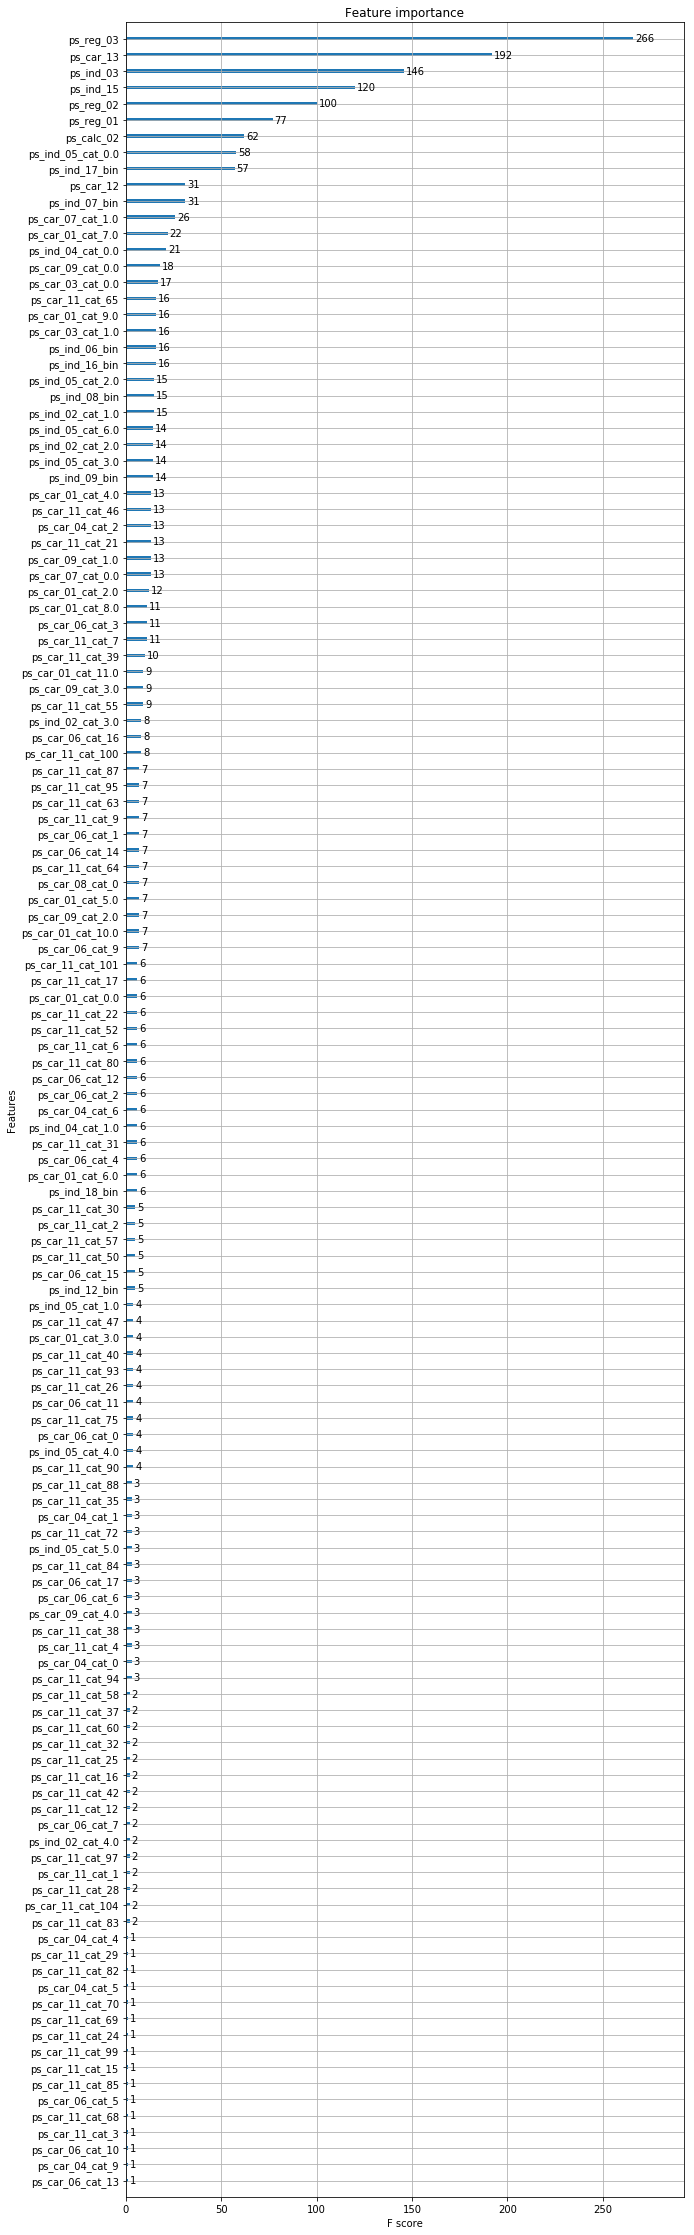

In [238]:
f, ax = plt.subplots(1,1, figsize=(10,40))
xgb.plot_importance(model, ax=ax)
plt.show()

### Step2, Gamma

In [239]:
gridsearch_params = [
    {'gamma':i/10.0}
    for i in np.arange(0,5)
]

In [240]:
%%time
model_tuning(params, gridsearch_params, dtrain_t, 500)

CV with gamma : 0.0  
 Gini normalized 0.272266 for 199 rounds
CV with gamma : 0.1  
 Gini normalized 0.272266 for 199 rounds
CV with gamma : 0.2  
 Gini normalized 0.272266 for 199 rounds
CV with gamma : 0.3  
 Gini normalized 0.272266 for 199 rounds
CV with gamma : 0.4  
 Gini normalized 0.272266 for 199 rounds
Best params: [0.0], Gini_normalized: 0.272266
Wall time: 20min 55s


### Step3, subsample, colsample_bytree

In [243]:
gridsearch_params = [
    {'subsample':i/10.0, 'colsample_bytree':j/10.0}
    for i in np.arange(6,11)
    for j in np.arange(6,11)
]

In [244]:
%%time
model_tuning(params, gridsearch_params, dtrain_t, 200)

CV with subsample : 0.6  colsample_bytree : 0.6  
 Gini normalized 0.27213260000000006 for 195 rounds
CV with subsample : 0.6  colsample_bytree : 0.7  
 Gini normalized 0.2728254 for 184 rounds
CV with subsample : 0.6  colsample_bytree : 0.8  
 Gini normalized 0.27147580000000004 for 197 rounds
CV with subsample : 0.6  colsample_bytree : 0.9  
 Gini normalized 0.2729336 for 196 rounds
CV with subsample : 0.7  colsample_bytree : 0.6  
 Gini normalized 0.2721066 for 199 rounds
CV with subsample : 0.7  colsample_bytree : 0.7  
 Gini normalized 0.2717556 for 160 rounds
CV with subsample : 0.7  colsample_bytree : 0.8  
 Gini normalized 0.27257260000000005 for 199 rounds
CV with subsample : 0.7  colsample_bytree : 0.9  
 Gini normalized 0.2729506 for 199 rounds
CV with subsample : 0.8  colsample_bytree : 0.6  
 Gini normalized 0.2735928 for 199 rounds
CV with subsample : 0.8  colsample_bytree : 0.7  
 Gini normalized 0.2732852 for 193 rounds
CV with subsample : 0.8  colsample_bytree : 0.8  


### Step4. reg_alpha

In [247]:
alpha = [1e-5, 1e-2, 0.1, 1, 100]
gridsearch_params = [
    {'reg_alpha': i}
    for i in alpha
]

In [248]:
%%time
model_tuning(params, gridsearch_params, dtrain_t, 1000)

CV with reg_alpha : 1e-05  
 Gini normalized 0.2739274 for 180 rounds
CV with reg_alpha : 0.01  
 Gini normalized 0.273219 for 212 rounds
CV with reg_alpha : 0.1  
 Gini normalized 0.2740022 for 212 rounds
CV with reg_alpha : 1  
 Gini normalized 0.2747392 for 223 rounds
CV with reg_alpha : 100  
 Gini normalized 0.2697474 for 840 rounds
Best params: [1], Gini_normalized: 0.2747392
Wall time: 32min 41s


In [254]:
alpha = [17, 20, 23]
gridsearch_params = [
    {'reg_alpha': i}
    for i in alpha
]

In [255]:
%%time
model_tuning(params, gridsearch_params, dtrain_t, 1000)

CV with reg_alpha : 17  
 Gini normalized 0.2759754 for 348 rounds
CV with reg_alpha : 20  
 Gini normalized 0.2753002 for 329 rounds
CV with reg_alpha : 23  
 Gini normalized 0.2750898 for 350 rounds
Best params: [17], Gini_normalized: 0.2759754
Wall time: 20min 14s


In [256]:
watchlist = [(dtrain,'train'), (dval,'validation')]
model = xgb.train(params, dtrain, num_boost_round=1000, evals=watchlist, 
                  feval=gini_normalized, maximize=True, verbose_eval=10, early_stopping_rounds=20)

[0]	train-error:0.036352	validation-error:0.03667	train-gini_normal:0.178484	validation-gini_normal:0.169506
Multiple eval metrics have been passed: 'validation-gini_normal' will be used for early stopping.

Will train until validation-gini_normal hasn't improved in 20 rounds.
[10]	train-error:0.036352	validation-error:0.03667	train-gini_normal:0.223192	validation-gini_normal:0.215532
[20]	train-error:0.036352	validation-error:0.03667	train-gini_normal:0.228579	validation-gini_normal:0.220373
[30]	train-error:0.036352	validation-error:0.03667	train-gini_normal:0.245696	validation-gini_normal:0.2399
[40]	train-error:0.036352	validation-error:0.03667	train-gini_normal:0.258102	validation-gini_normal:0.251371
[50]	train-error:0.036352	validation-error:0.03667	train-gini_normal:0.267194	validation-gini_normal:0.260803
[60]	train-error:0.036352	validation-error:0.03667	train-gini_normal:0.273252	validation-gini_normal:0.265943
[70]	train-error:0.036352	validation-error:0.03667	train-gini_no

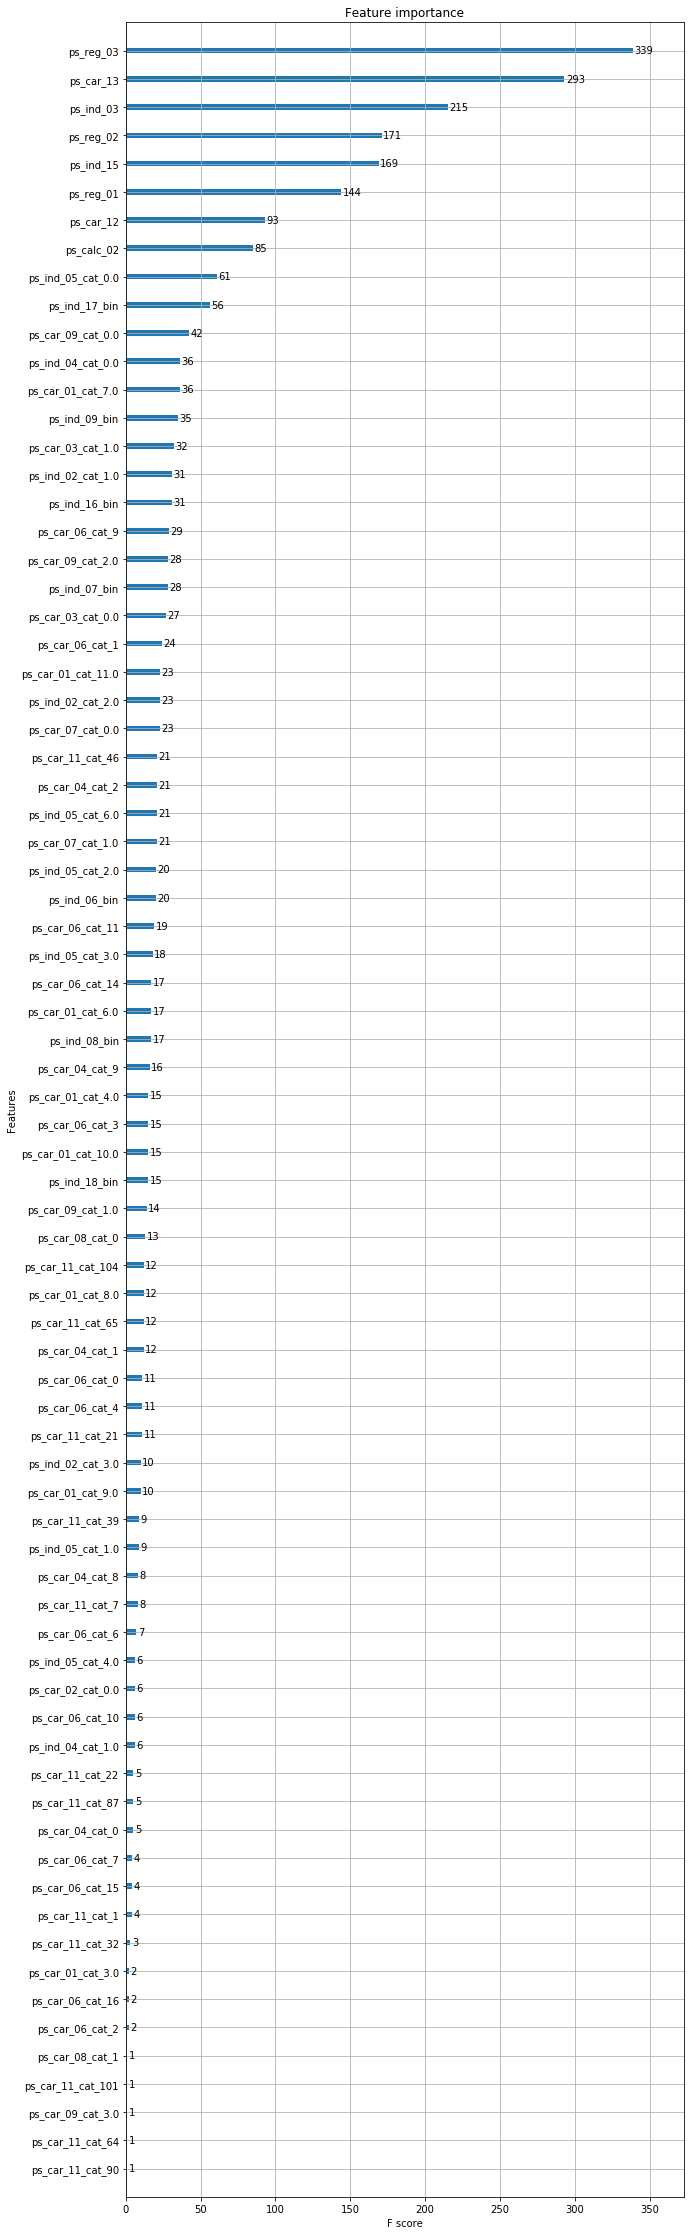

In [257]:
f, ax = plt.subplots(1,1, figsize=(10,40))
xgb.plot_importance(model, ax=ax)
plt.show()

In [282]:
params

{'learning_rate': 0.1,
 'n_estimators': 200,
 'max_depth': 3,
 'min_child_weight': 6,
 'gamma': 0.4,
 'subsample': 1,
 'colsample_bytree': 1,
 'objective': 'gpu:binary:logistic',
 'nthread': 4,
 'scale_pos_weight': 1,
 'tree_method': 'gpu_hist',
 'predictor': 'gpu_predictor',
 'reg_alpha': 23}

### Save feature scoreing

In [263]:
filename = 'f_score6.csv'

value = pd.Series(model.get_fscore()).sort_values(ascending=False)
ranking = pd.DataFrame({'id':value.index, 'value':value, 'rank':list(range(1,len(value)+1))})
idx_df = pd.DataFrame({'id':train_origin.columns[2:], 'idx':list(range(1,len(train_origin.columns[2:])+1))})
f_score_df = pd.merge(ranking,idx_df, how='right')
f_score_df = f_score_df.sort_values(by='idx')
f_score_df.to_csv('../../input/' + filename)
f_score_df

,id,value,rank,idx
76,ps_ind_01,NaN,NaN,1
2,ps_ind_03,215.0,3.0,2
30,ps_ind_06_bin,20.0,31.0,3
19,ps_ind_07_bin,28.0,20.0,4
34,ps_ind_08_bin,17.0,35.0,5
13,ps_ind_09_bin,35.0,14.0,6
77,ps_ind_10_bin,NaN,NaN,7
78,ps_ind_11_bin,NaN,NaN,8
79,ps_ind_12_bin,NaN,NaN,9
80,ps_ind_13_bin,NaN,NaN,10


## 6. Submission

In [278]:
test_pred = model.predict(dtest)

In [281]:
filename = 'submission11.csv'
pd.DataFrame({'id':test_idx, 'target':test_pred}).to_csv('../../input/' + filename,index=False)